Copyright 2016 Intel Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# fMRI Simulator example script for multivariate analyses

Example script to demonstrate fmrisim functionality. This generates
data for a two condition, event related design in which each condition
evokes different activity within the same voxels. It then runs simple 
univariate and multivariate analyses on the data

Authors: Cameron Ellis (Yale) 2017


### **1.	Set parameters.** 

It is necessary to set various parameters that describe how the signal and the noise will be generated.

*1.1 Import necessary Python packages*

In [5]:
%matplotlib notebook

from pathlib import Path
from brainiak.utils import fmrisim
import nibabel
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.spatial.distance as sp_distance
import sklearn.manifold as manifold
import scipy.stats as stats
import sklearn.model_selection
import sklearn.svm

/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
import sys;

In [7]:
sys.path.append('/Users/cellis/Documents/MATLAB/Analysis_BrainIAK/')

*1.2 Load participant data*

Any 4 dimensional fMRI data that is readible by nibabel can be used as input to this pipeline. For this example, data is taken from the open access repository DataSpace: http://arks.princeton.edu/ark:/88435/dsp01dn39x4181. This file is unzipped and placed in the home directory with the name Corr_MVPA 

In [8]:
home = str(Path.home())
nii = nibabel.load(home + '/Corr_MVPA/Participant_01_rest_run01.nii')
volume = nii.get_data()

*1.2	Specify participant dimensions and resolution*

The size of the volume and the resolution of the voxels must be specified (or extracted from the real data as is the case below).

In [9]:
dim = volume.shape  # What is the size of the volume
dimsize = nii.header.get_zooms()  # Get voxel dimensions from the nifti header
tr = dimsize[3]
if tr > 100:  # If high then these values are likely in ms
    tr /= 1000
print(dim)

(64, 64, 27, 294)


*1.3 Generate an activity template and a mask*

Functions in fmrisim require a continuous map that describes the appropriate average MR value for each voxel in the brain and a mask which specifies voxels in the brain versus voxels outside of the brain. One way to generate both of these volumes is the mask_brain function. At a minimum, this takes as an input the fMRI volume to be simulated. To create the template this volume is averaged over time and bounded to a range from 0 to 1. In other words, voxels with a high value in the template have high activity over time. To create a mask, the template is thresholded.  This threshold can be set manually or instead an appropriate value can be determined by looking for the minima between the two first peaks in the histogram of voxel values. If you would prefer, you could use the [compute_epi_mask](http://nilearn.github.io/modules/generated/nilearn.masking.compute_epi_mask.html) function in nilearn which uses a similar method.

In [10]:
mask, template = fmrisim.mask_brain(volume=volume, 
                                    mask_self=True,
                                    )

*1.4 Determine noise parameters*

A critical step in the fmrisim toolbox is determining the noise parameters of the volume to be created. Many noise parameters are available for specification and if any are not set then they will default to reasonable values. As mentioned before, it is instead possible to provide raw fMRI data that will be used to estimate these noise parameters. The goal of the noise estimation is to calculate general descriptive statistics about the noise in the brain that are thought to be important. The simulations are then useful for understanding how signals will survive analyses when embedded in realistic neural noise. 

Now the disclaimers: the values here are only an estimate and will depend on noise properties combining in the ways assumed. In addition, because of the non-linearity and stochasticity of this simulation, this estimation is not fully invertible: if you generate a dataset with a set of noise parameters it will have similar but not the same noise parameters as a result. Moreover, complex interactions between brain regions that likely better describe brain noise are not modelled here: this toolbox pays no attention to regions of the brain or their interactions. Finally, for best results use raw fMRI because if the data has been preprocessed then assumptions this algorithm makes are likely to be erroneous. For instance, if the brain has been masked then this will eliminate variance in non-brain voxels which will mean that calculations of noise dependent on those voxels as a reference will fail.

This toolbox separates noise in two: spatial noise and temporal noise. To estimate spatial noise both the smoothness and the amount of non-brain noise of the data must be quantified. For smoothness, the Full Width Half Max (FWHM) of the volume is averaged for the X, Y and Z dimension and then averaged across a sample of time points. To calculate the Signal to Noise Ratio (SNR) the mean activity in brain voxels for the middle time point is divided by the standard deviation in activity across non-brain voxels for that time point. For temporal noise an Auto-regressive and moving average (ARMA) process is estimated, along with the overall size of temporal variability. A sample of brain voxels is used to estimate the first two AR components and the first MA component of each voxel's activity over time using the statsmodels package. The Signal to Fluctuation Noise Ratio (SFNR) is calculated by dividing the average activity of voxels in the brain with that voxel’s noise  (Friedman & Glover, 2006). That noise is calculated by taking the standard deviation of that voxel over time after it has been detrended with a second order polynomial. The SFNR then controls the amount of functional variability. Other types of noise can be generated, such as physiological noise, but are not estimated by this function.


In [11]:
# Calculate the noise parameters from the data
noise_dict = {'voxel_size': [dimsize[0], dimsize[1], dimsize[2]]}
noise_dict = fmrisim.calc_noise(volume=volume,
                                mask=mask,
                                template=template,
                                noise_dict=noise_dict,
                                )

/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/cellis/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: Runt

In [12]:
print('Noise parameters of the data were estimated as follows:')
print('SNR: ' + str(noise_dict['snr']))
print('SFNR: ' + str(noise_dict['sfnr']))
print('FWHM: ' + str(noise_dict['fwhm']))

Noise parameters of the data were estimated as follows:
SNR: 22.8951160877
SFNR: 70.7171164885
FWHM: 5.65314304468


### **2. Generate signal**
fmrisim can generate realistic fMRI noise when supplied with the appropriate inputs. A single function receives these inputs and deals with generating the noise. The necessary inputs are described below; however, the steps performed by this function are also described in detail for clarity.

In [13]:
# Calculate the noise given the parameters
noise = fmrisim.generate_noise(dimensions=dim[0:3],
                               tr_duration=int(tr),
                               stimfunction_tr=[0] * dim[3], 
                               mask=mask,
                               template=template,
                               noise_dict=noise_dict,
                               iterations=[50,0],
                               )

/Users/cellis/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


Terminated SNR and SFNR fit after 7 iterations.


<IPython.core.display.Javascript object>


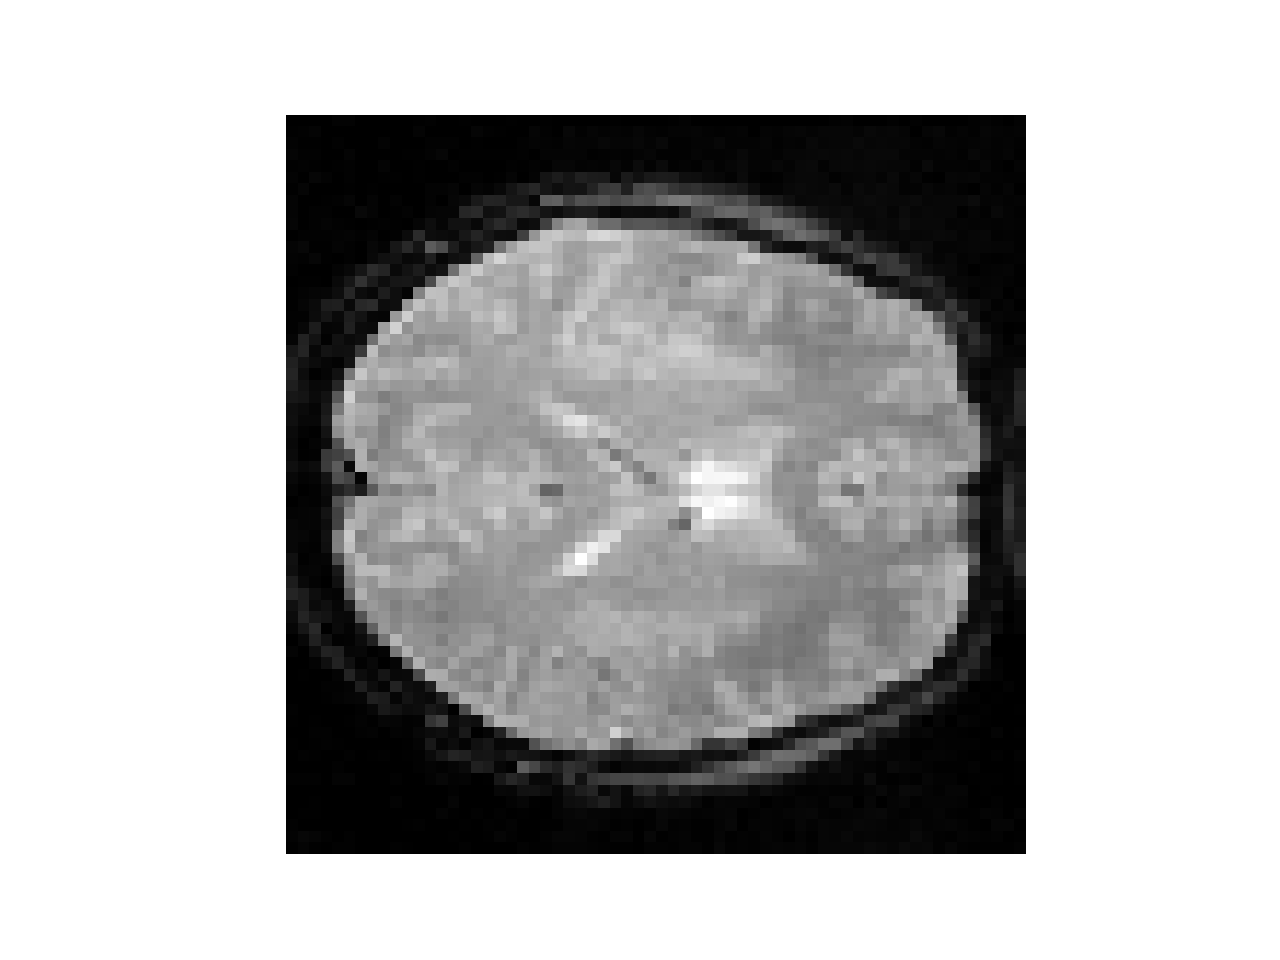

(-0.5, 63.5, 63.5, -0.5)

In [14]:
# Plot a slice through the noise brain
plt.figure()
plt.imshow(noise[:, :, int(dim[2] / 2), 0], cmap=plt.cm.gray)
plt.axis('off')

*2.1 Create temporal noise*

The temporal noise of fMRI data is comprised of multiple components: drift, autoregression, task related motion and physiological noise. To estimate drift, a number of cosine basis functions are combined. To estimate drift, cosine basis functions are combined, with longer runs being comprised of more basis functions (Welvaert, et al., 2011). This drift is then multiplied by a three-dimensional volume of Gaussian random fields of a specific FWHM. Autoregression noise is estimated by initializing with a brain shaped volume of gaussian random fields and then multiplying then creating an ARMA time course by adding additional volumes of noise. Physiological noise is modeled by sine waves comprised of heart rate (1.17Hz) and respiration rate (0.2Hz) (Biswal, et al., 1996) with random phase. This time course is also multiplied by brain shaped spatial noise. Finally, task related noise is simulated by adding Gaussian or Rician noise to time points where there are events (according to the event time course) and in turn this is multiplied by a brain shaped spatial noise volume. These four noise components are then mixed together in proportion to the size of their corresponding sigma values. This aggregated volume is then Z scored and the SFNR is used to estimate the appropriate standard deviation of these values across time. 

<IPython.core.display.Javascript object>


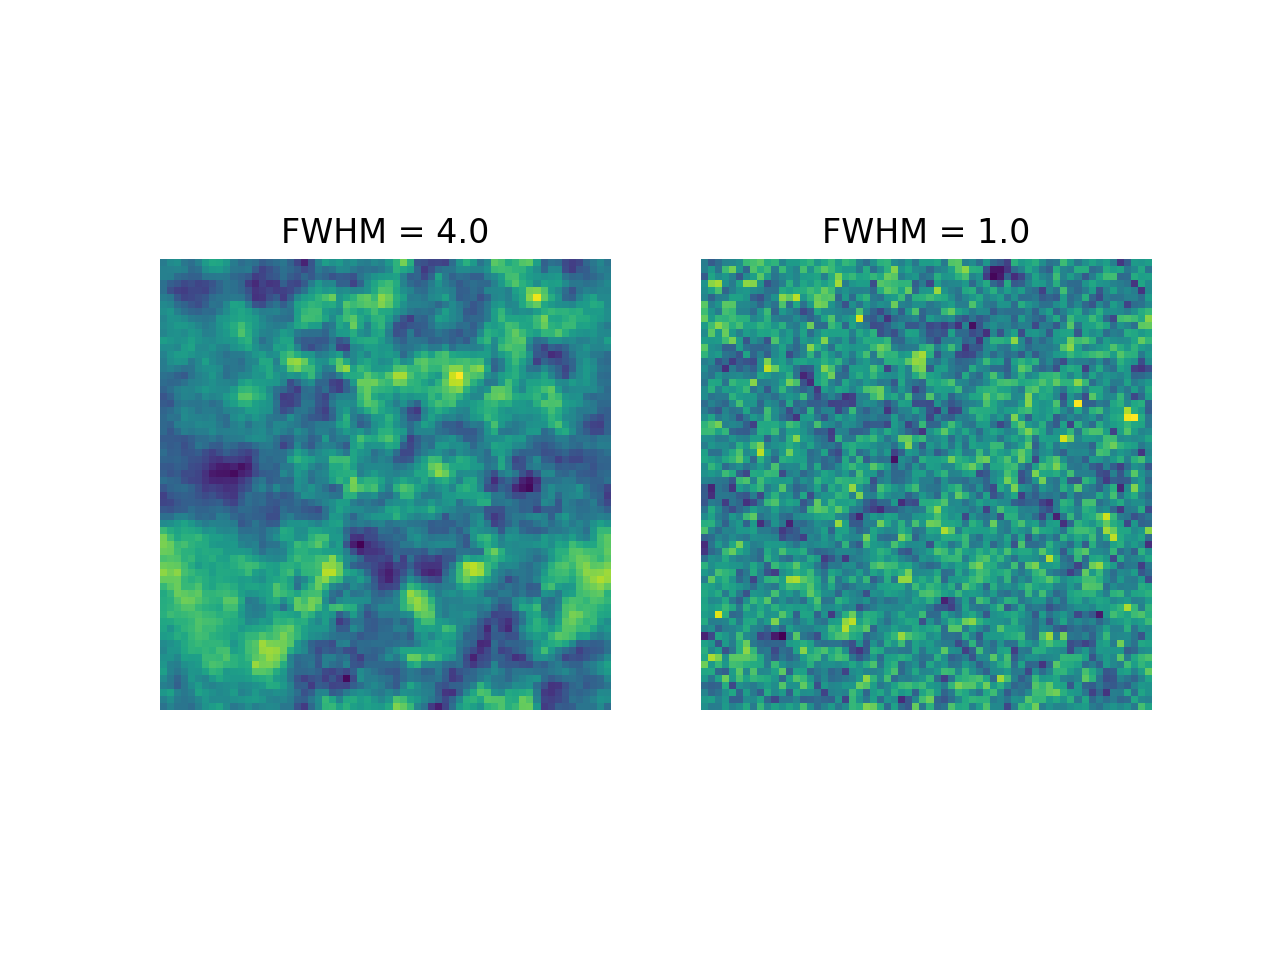

(-0.5, 63.5, 63.5, -0.5)

In [15]:
# Plot spatial noise
low_spatial = fmrisim._generate_noise_spatial(dim[0:3],
                                              fwhm=4.0,
                                              )

high_spatial = fmrisim._generate_noise_spatial(dim[0:3],
                                               fwhm=1.0,
                                               )
plt.figure()
plt.subplot(1,2,1)
plt.title('FWHM = 4.0')
plt.imshow(low_spatial[:, :, 12])
plt.axis('off')

plt.subplot(1,2,2)
plt.title('FWHM = 1.0')
plt.imshow(high_spatial[:, :, 12])
plt.axis('off')

In [16]:
# Create the different types of noise
total_time = 500
timepoints = list(range(0, total_time, int(tr)))

drift = fmrisim._generate_noise_temporal_drift(total_time,
                                               int(tr),
                                               )

mini_dim = np.array([2, 2, 2])
autoreg = fmrisim._generate_noise_temporal_autoregression(timepoints,
                                                          noise_dict,
                                                          mini_dim,
                                                          np.ones(mini_dim),
                                                          np.ones(mini_dim),
                                                          )
            
phys = fmrisim._generate_noise_temporal_phys(timepoints,
                                            )

stimfunc = np.zeros((int(total_time / tr), 1))
stimfunc[np.random.randint(0, int(total_time / tr), 50)] = 1
task = fmrisim._generate_noise_temporal_task(stimfunc,
                                            )

<IPython.core.display.Javascript object>


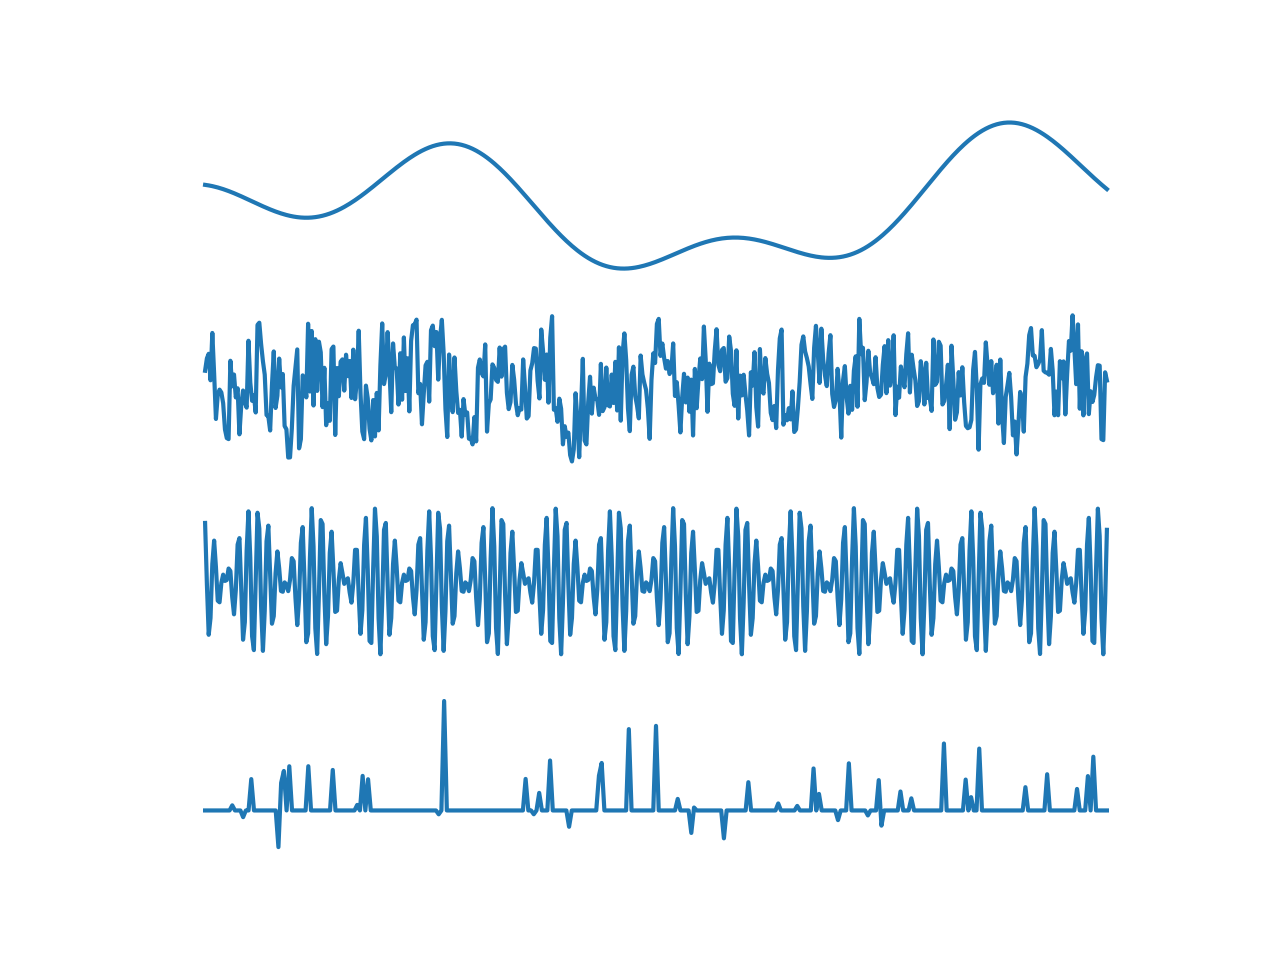

In [17]:
# Plot the different noise types
plt.figure()
plt.title('Noise types')

plt.subplot(4, 1, 1)
plt.plot(drift)
plt.axis('off')
plt.xlabel('Drift')

plt.subplot(4, 1, 2)
plt.plot(autoreg[0, 0, 0, :])
plt.axis('off')
plt.xlabel('Autoregression')

plt.subplot(4, 1, 3)
plt.plot(phys)
plt.axis('off')
plt.xlabel('Physiological')

plt.subplot(4, 1, 4)
plt.plot(task)
plt.axis('off')
plt.xlabel('Task')

*2.2 Create system noise*
    
In addition to temporal noise from fluctuations in the scanner there is also machine noise that causes fluctuations in all voxels. When SNR is low, Rician noise is a good estimate of background noise data (Gudbjartsson, & Patz, 1995). However if you look at the distribution of voxel values averaged across time then you see that this is also rician, suggesting that most of the rician noise is a result of the structure in the background of the brain (e.g. the baseline MR of the head coil or skull). If you subtract this baseline then the noise becomes approximately gaussian, especially in the regions far from the brain (which is what the calc_noise algorithm considers when calculating SNR). Hence the machine noise here is gaussian added to an inherently rician baseline.

Below we take the distribution of voxel intensity for voxels that are more than 5 units away from the brain voxels. We then plot those voxels as a histogram at the first timepoint. Next we take a sample of voxels and display the distribution of intensity for these voxels over time, the lines indicating that the values are relatively stable. The last plot shows the distribution of values for the non-brain voxels after their baseline is removed which is a kurtotic gaussian (the peak reflects zero values).

<IPython.core.display.Javascript object>


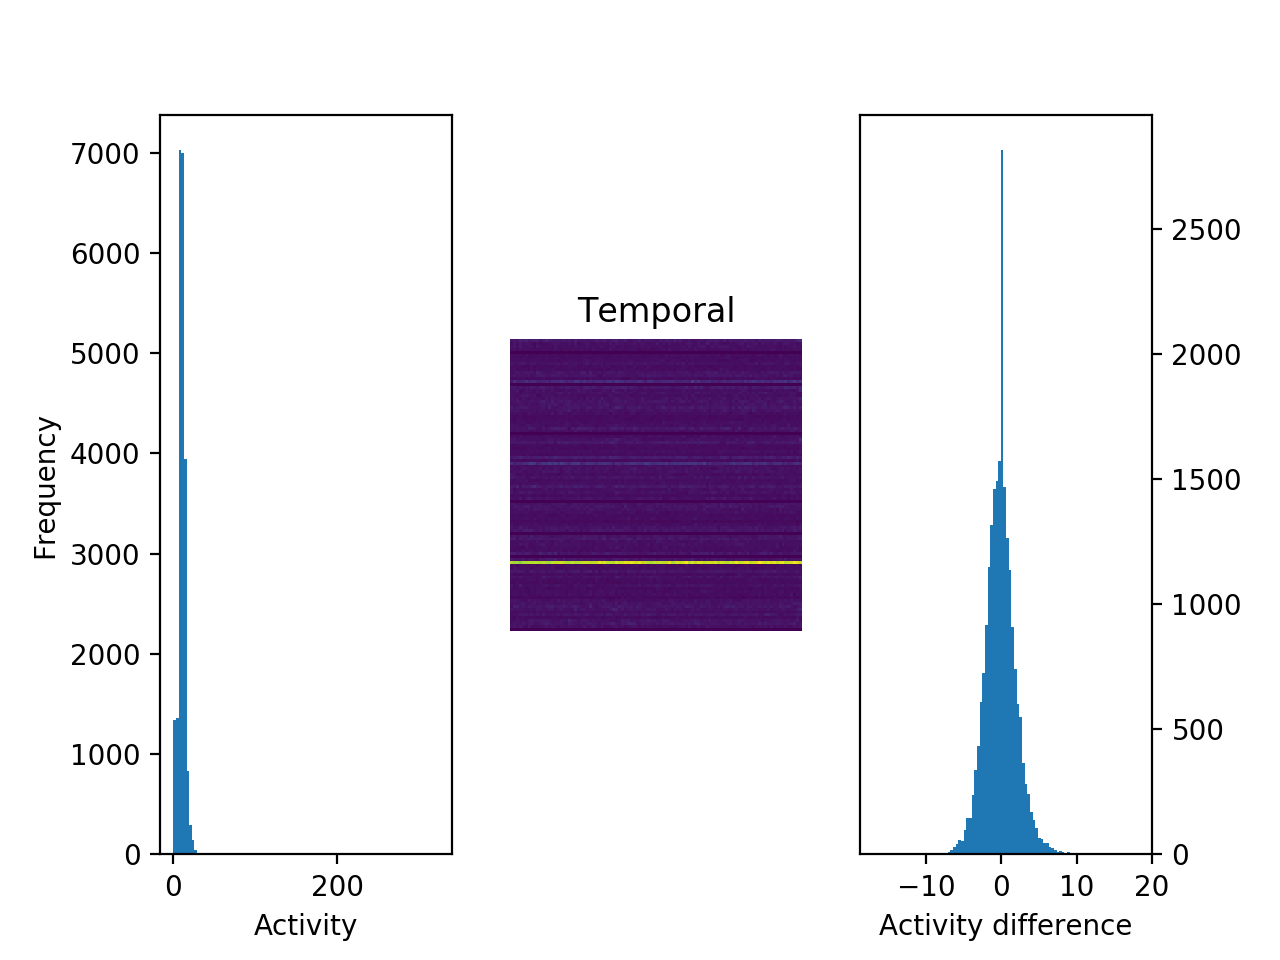

In [18]:
# Dilate the mask so as to only take voxels far from the brain (performed in calc_noise)
mask_dilated = ndimage.morphology.binary_dilation(mask, iterations=10)

# Remove all non brain voxels
system_all = volume[mask_dilated == 0]  # Pull out all the non brain voxels in the first TR
system_baseline = volume - (template.reshape(dim[0], dim[1], dim[2], 1) * noise_dict['max_activity'])  # Subtract the baseline before masking
system_baseline = system_baseline[mask_dilated == 0]

# Plot the distribution of voxels
plt.figure()
plt.subplot(1, 3, 1)
plt.hist(system_all[:,0].flatten(),100)
plt.xlabel('Activity')
plt.ylabel('Frequency')

# Identify a subset of voxels to plot
idxs = list(range(system_all.shape[0]))
np.random.shuffle(idxs)

temporal = system_all[idxs[:100], :100]
plt.subplot(1, 3, 2)
plt.imshow(temporal)
plt.axis('off')
plt.title('Temporal')

# Plot the difference
ax=plt.subplot(1, 3, 3)
plt.hist(system_baseline[:,0].flatten(),100)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xlabel('Activity difference')

*2.3 Combine noise and template*
    
The template volume is used to estimate the appropriate baseline distribution of MR values. This estimate is then combined with the temporal noise and the system noise to make an estimate of the noise. 

*2.4 Fit the data to the noise parameters*

The generate_noise function does its best to estimate the appropriate noise parameters using assumptions about noise sources; however, because of the complexity of these different noise types, it is often wrong. To compensate, fitting is performed in which parameters involved in the noise generation process are changed and the noise metrics are recalculated to see whether those changes helped the fit. Due to their importance, the parameters that can be fit are SNR, SFNR and AR.

The fitting of SNR/SFNR involves reweighting spatial and temporal metrics of noise. This analysis is relatively quick because this reweighting does not require that any timecourses are recreated, only that they are reweighted. At least 10 iterations are recommended because the initial guesses tend to underestimate SFNR and SNR (although the size of this error depends on the data). In the case of fitting the AR, the MA rho is adjusted until the AR is appropriate and in doing so the timecourse needs to be recreated for each iteration. The default number of AR iterations is 0 because by default these values are in an appropriate range. However, at least 10 iterations are needed if you wish to match your output data to the exact input data.

In terms of timing, for a medium size dataset (64x64x27x294 voxels) it takes approximately 23s to generate the data with 0 iterations on a Mac 2014 laptop. For every iteration of fitting the SNR/SFNR, it takes an additional 3s and for every additional iteration of fitting AR it takes an additional 10s (these combine linearly).

In [19]:
# Compute the noise parameters for the simulated noise
noise_dict_sim = {'voxel_size': [dimsize[0], dimsize[1], dimsize[2]]}
noise_dict_sim = fmrisim.calc_noise(volume=noise,
                                    mask=mask,
                                    template=template,
                                    noise_dict=noise_dict_sim,
                                    )

In [20]:
print('SNR: %0.2f vs %0.2f' % (noise_dict['snr'], noise_dict_sim['snr']))

SNR: 22.90 vs 21.93


In [21]:
print('Compare noise parameters for the real and simulated noise:')
print('SNR: %0.2f vs %0.2f' % (noise_dict['snr'], noise_dict_sim['snr']))
print('SFNR: %0.2f vs %0.2f' % (noise_dict['sfnr'], noise_dict_sim['sfnr']))
print('FWHM: %0.2f vs %0.2f' % (noise_dict['fwhm'], noise_dict_sim['fwhm']))

Compare noise parameters for the real and simulated noise:
SNR: 22.90 vs 21.93
SFNR: 70.72 vs 70.75
FWHM: 5.65 vs 5.71


### **3. Generate signal**

fmrisim can be used to generate signal in a number of different ways depending on the type of effect being simulated. Several tools are supplied to help with different types of signal that may be required; however, custom scripts may be necessary for unique effects. Below an experiment will be simulated in which two conditions, A and B, evoke different patterns of activity in the same set of voxels in the brain. This pattern does not manifest as a univariate change in voxel activity across voxels but instead each condition evokes a consistent pattern across voxels. These conditions are randomly intermixed trial by trial. This code could be easily changed to instead compare univariate changes  evoked by stimuli in different brain regions. 

*3.1 Specify which voxels in the brain contain signal*

fmrisim provides tools to specify certain voxels in the brain that contain signal. The generate_signal function can produce regions of activity in a brain of different shapes, such as cubes, loops and spheres. Alternatively a volume could be loaded in that specifies the signal voxels (e.g. for ROIs from nilearn). The value of each voxel can be specified here, or set to be a random value.

In [22]:
# Create the region of activity where signal will appear
coordinates = np.array([[21, 21, 21]])  # Where in the brain is the signal
feature_size = 3  # How big, in voxels, is the size of the ROI
signal_volume = fmrisim.generate_signal(dimensions=dim[0:3],
                                        feature_type=['cube'],
                                        feature_coordinates=coordinates,
                                        feature_size=[feature_size],
                                        signal_magnitude=[1],
                                        )

<IPython.core.display.Javascript object>


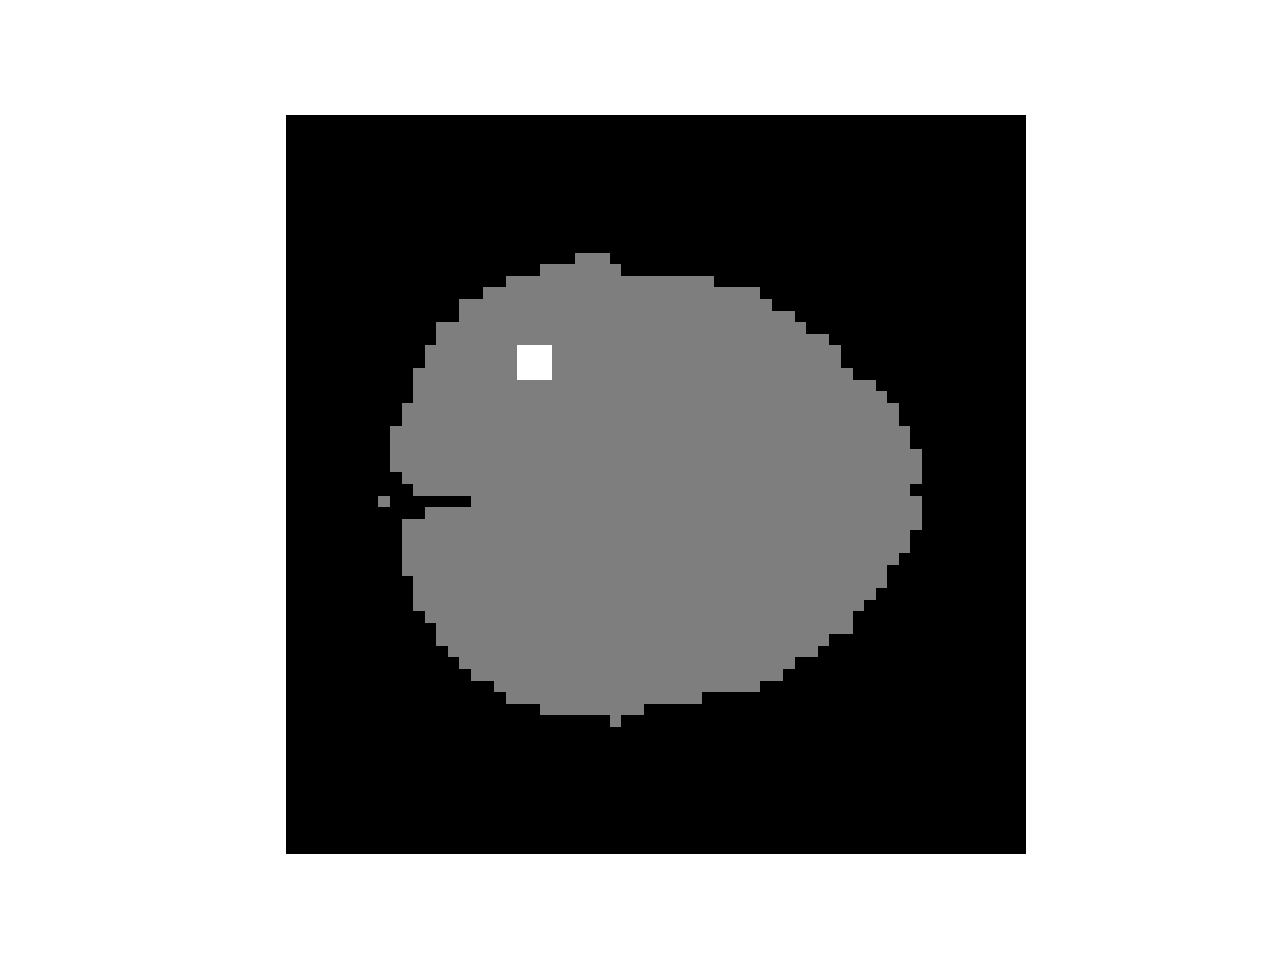

(-0.5, 63.5, 63.5, -0.5)

In [23]:
plt.figure()
plt.imshow(signal_volume[:, :, 21], cmap=plt.cm.gray)
plt.imshow(mask[:, :, 21], cmap=plt.cm.gray, alpha=.5)
plt.axis('off')

*3.2 Characterize signal for voxels*

Specify the pattern of activity across a given number of voxels that characterizes each condition. This pattern can simply be random, as is done here, or can be structured, like the position of voxels in high dimensional representation space.

In [24]:
# Create a pattern for each voxel in our signal ROI
voxels = feature_size ** 3

# Pull the conical voxel activity from a uniform distribution
pattern_A = np.random.rand(voxels).reshape((voxels, 1))  
pattern_B = np.random.rand(voxels).reshape((voxels, 1))

In [ ]:
print(pattern_A.mean())
print(pattern_A.mean())


<IPython.core.display.Javascript object>


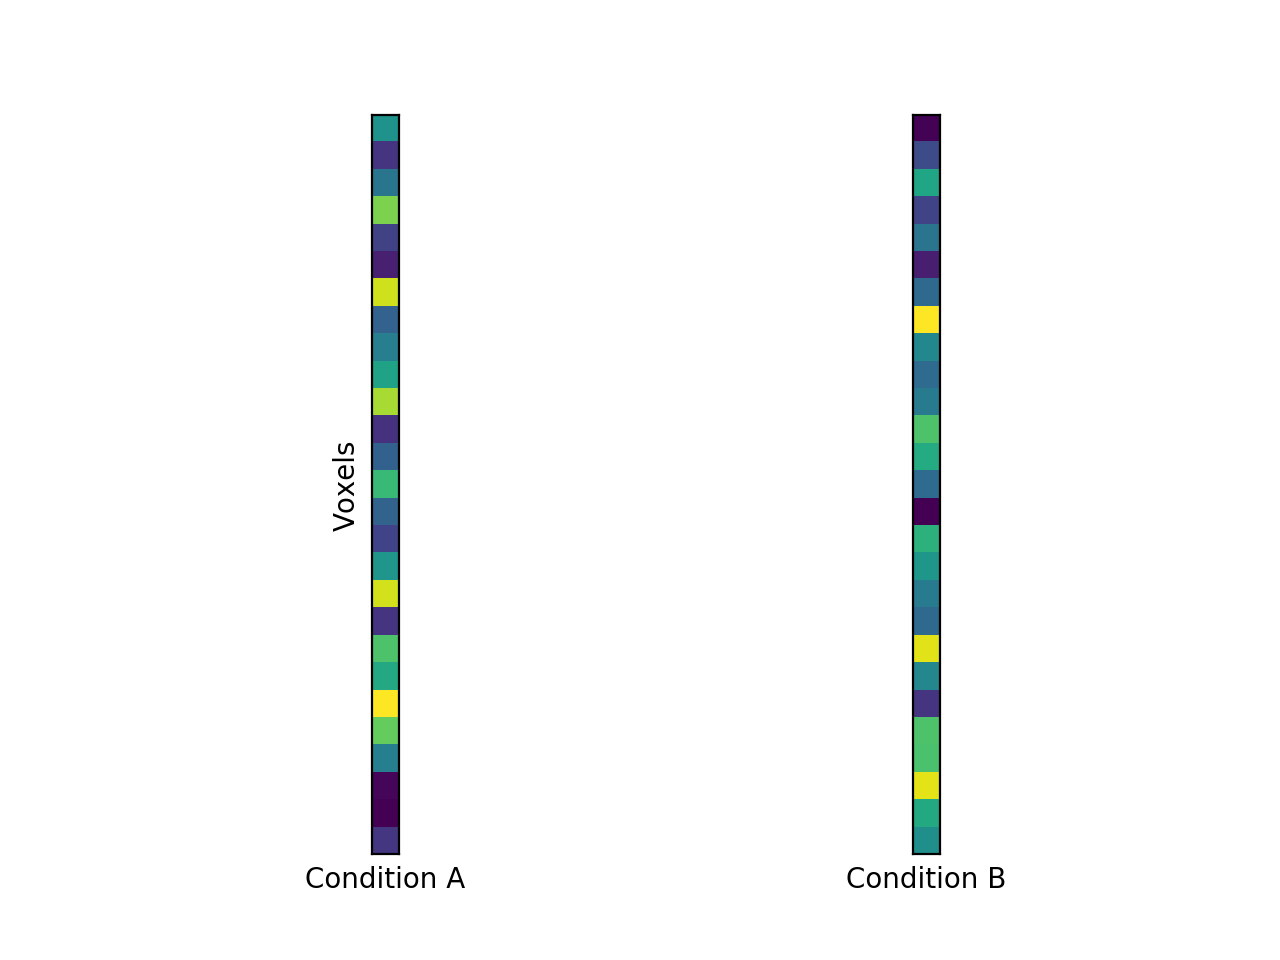

In [25]:
# Plot pattern of activity for each condition
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pattern_A)
plt.ylabel('Voxels')
plt.tick_params(which='both', left='off', labelleft='off', bottom='off', labelbottom='off')
plt.xlabel('Condition A')

plt.subplot(1,2,2)
plt.imshow(pattern_B)
plt.tick_params(which='both', left='off', labelleft='off', bottom='off', labelbottom='off')
plt.xlabel('Condition B')

*3.3 Generate event time course*

generate_stimfunction can be used to specify the time points at which task stimulus events occur.  The timing of events can be specified by describing the onset and duration of each event. Alternatively, it is possible to provide a path to a 3 column timing file, used by fMRI software packages like FSL, which specifies event onset, duration and weight. 


In [30]:
# Set up stimulus event time course parameters
event_duration = 2  # How long is each event
isi = 7  # What is the time between each event
burn_in = 1  # How long before the first event

total_time = int(dim[3] * tr) + burn_in  # How long is the total event time course
events = int((total_time - ((event_duration + isi) * 2))  / ((event_duration + isi) * 2)) * 2  # How many events are there?
onsets_all = np.linspace(burn_in, events * (event_duration + isi), events)  # Space the events out
np.random.shuffle(onsets_all)  # Shuffle their order
onsets_A = onsets_all[:int(events / 2)]  # Assign the first half of shuffled events to condition A
onsets_B = onsets_all[int(events / 2):]  # Assign the second half of shuffled events to condition B
temporal_res = 10.0 # How many timepoints per second of the stim function are to be generated?

In [31]:
# Create a time course of events 
stimfunc_A = fmrisim.generate_stimfunction(onsets=onsets_A,
                                           event_durations=[event_duration],
                                           total_time=total_time,
                                           temporal_resolution=temporal_res,
                                           )

stimfunc_B = fmrisim.generate_stimfunction(onsets=onsets_B,
                                           event_durations=[event_duration],
                                           total_time=total_time,
                                           temporal_resolution=temporal_res,
                                           )

*3.4 Export stimulus time course for analysis*

If a time course of events is generated, as is the case here, it may be useful to store this in a certain format for future analyses. The export_3_column function can be used to export the time course to be a three column (event onset, duration and weight) timing file that might readable to FSL. Alternatively, the export_epoch_file function can be used to export numpy files that are necessary inputs for MVPA and FCMA in BrainIAK.


In [32]:
fmrisim.export_epoch_file(stimfunction=[np.hstack((stimfunc_A, stimfunc_B))],
                          filename=home + '/epoch_file.npy',
                          tr_duration=tr,
                          temporal_resolution=temporal_res,
                          )

fmrisim.export_3_column(stimfunction=stimfunc_A,
                        filename=home + '/Condition_A.txt',
                        temporal_resolution=temporal_res,
                        )

fmrisim.export_3_column(stimfunction=stimfunc_B,
                        filename=home + '/Condition_B.txt',
                        temporal_resolution=temporal_res,
                        )

*3.5 Estimate the voxel weight for each event*

According to the logic of this example, each signal voxel will respond a different amount for condition A and B, but this amount will also differ across voxels. To simulate this we multiply a voxel’s response to each condition by the time course of events and then combine these conditions time courses to make a single time course. This time course describes each voxel’s response to stimuli over time.

In [33]:
# Multiply each pattern by each voxel time course
weights_A = np.matlib.repmat(stimfunc_A, 1, voxels).transpose() * pattern_A
weights_B = np.matlib.repmat(stimfunc_B, 1, voxels).transpose() * pattern_B

# Sum these time courses together
stimfunc_weighted = weights_A + weights_B
stimfunc_weighted = stimfunc_weighted.transpose()

*3.6 Convolve each voxel’s time course with the Hemodynamic Response Function*

With the time course of stimulus events it is necessary to estimate the brain’s response to those events, which can be estimated by convolving it with using a Hemodynamic Response Function (HRF). By default, convolve_hrf assumes a double gamma HRF appropriately models a brain’s response to events, as modeled by fMRI (Friston, et al., 1998). To do this, each voxel’s time course is convolved to make a function of the signal activity. Hence this produces an estimate of the voxel’s activity, after considering the temporal blurring of the HRF. This can take a single vector of events or multiple time courses.

In [34]:
signal_func = fmrisim.convolve_hrf(stimfunction=stimfunc_weighted,
                                   tr_duration=tr,
                                   temporal_resolution=temporal_res,
                                   scale_function=1,
                                   )

<IPython.core.display.Javascript object>


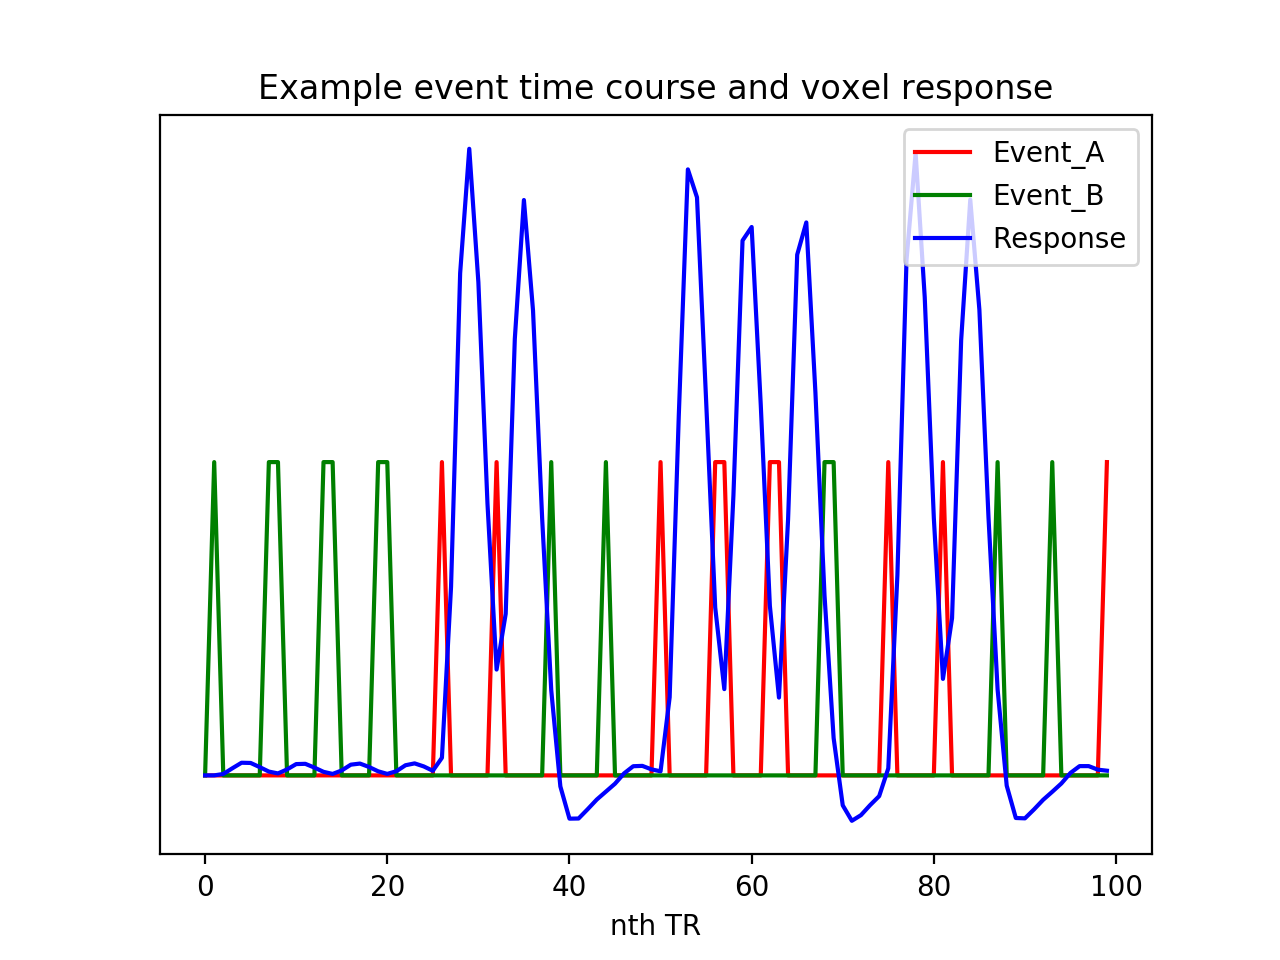

In [35]:
# Prepare the data to be plotted
response = signal_func[0:100,0] * 2
downsample_A = stimfunc_A[0:int(100*temporal_res * tr):int(temporal_res * tr), 0]
downsample_B = stimfunc_B[0:int(100*temporal_res * tr):int(temporal_res * tr), 0]

# Display signal
plt.figure()
plt.title('Example event time course and voxel response')
Event_A = plt.plot(downsample_A, 'r', label='Event_A')
Event_B = plt.plot(downsample_B, 'g', label='Event_B')
Response = plt.plot(response, 'b', label='Response')
plt.legend(loc=1)
plt.yticks([],'')
plt.xlabel('nth TR')

*3.7 Establish signal magnitude*

When specifying the signal we must determine the amount of activity change each voxel undergoes. fmrisim contains a tool to allow you to choose between a variety of different metrics that you could use to scale the signal. For instance, we can calculate percent signal change (referred to as PSC) by taking the average activity of voxels in an ROI of the noise volume and multiplying it by a proportion to signal the percentage change that this signal maximally evokes. This metric doesn't take account of the variance in the noise but other metrics available do. One metric that does take account of variance, and is used below, is the signal amplitude divided by the temporal variability. The choices that are available for computing the signal scale are based on Welvaert and Rosseel (2013).

In [36]:
# Specify the parameters for signal
signal_method = 'CNR_Amp/Noise-SD'
signal_magnitude = [0.5]

# Where in the brain are there stimulus evoked voxels
signal_idxs = np.where(signal_volume == 1)

# Pull out the voxels corresponding to the noise volume
noise_func = noise[signal_idxs[0], signal_idxs[1], signal_idxs[2], :]

In [37]:
# Compute the signal appropriate scaled
signal_func_scaled = fmrisim.compute_signal_change(signal_func,
                                                  noise_func,
                                                  noise_dict,
                                                  magnitude=signal_magnitude,
                                                  method=signal_method,
                                                  )

*3.8 Multiply the convolved response with the signal voxels*

If you have a time course of simulated response for one or more voxels and a three dimensional volume representing voxels that ought to respond to these events then apply_signal will combine these appropriately. This function multiplies each signal voxel in the brain by the convolved event time course. 

In [38]:
signal = fmrisim.apply_signal(signal_func_scaled,
                              signal_volume,
                              )

*3.9 Combine signal and noise*

Since the brain signal is expected to be small and sparse relative to the noise, it is assumed sufficient to simply add the volume containing signal with the volume modeling noise to make the simulated brain. 

In [39]:
brain = signal + noise

### **4. Analyse data**

Several tools are available for multivariate analysis in BrainIAK. These greatly speed up computation and are critical in some cases, such as a whole brain searchlight. However, for this example data we will only look at data in the ROI that we know contains signal.

*4.1 Pull out data for each trial*

Identify which voxels are in the signal ROI by using the coordinates provided earlier. To identify the relevant timepoints, assume that the peak of the neural response occurs 4 - 6s after each event onset. Take the TR corresponding to this peak response as the TR for that trial. In longer event/block designs you might instead average over each event.

In [40]:
hrf_lag = 4  # Assumed time from stimulus onset to HRF peak

# Get the lower and upper bounds of the ROI
lb = (coordinates - ((feature_size - 1) / 2)).astype('int')[0]
ub = (coordinates + ((feature_size - 1) / 2) + 1).astype('int')[0]

# Pull out voxels in the ROI for the specified timepoints
trials_A = brain[lb[0]:ub[0], lb[1]:ub[1], lb[2]:ub[2], ((onsets_A + hrf_lag) / tr).astype('int')]
trials_B = brain[lb[0]:ub[0], lb[1]:ub[1], lb[2]:ub[2], ((onsets_B + hrf_lag) / tr).astype('int')]

# Reshape data for easy handling
trials_A = trials_A.reshape((voxels, trials_A.shape[3]))
trials_B = trials_B.reshape((voxels, trials_B.shape[3]))

<IPython.core.display.Javascript object>


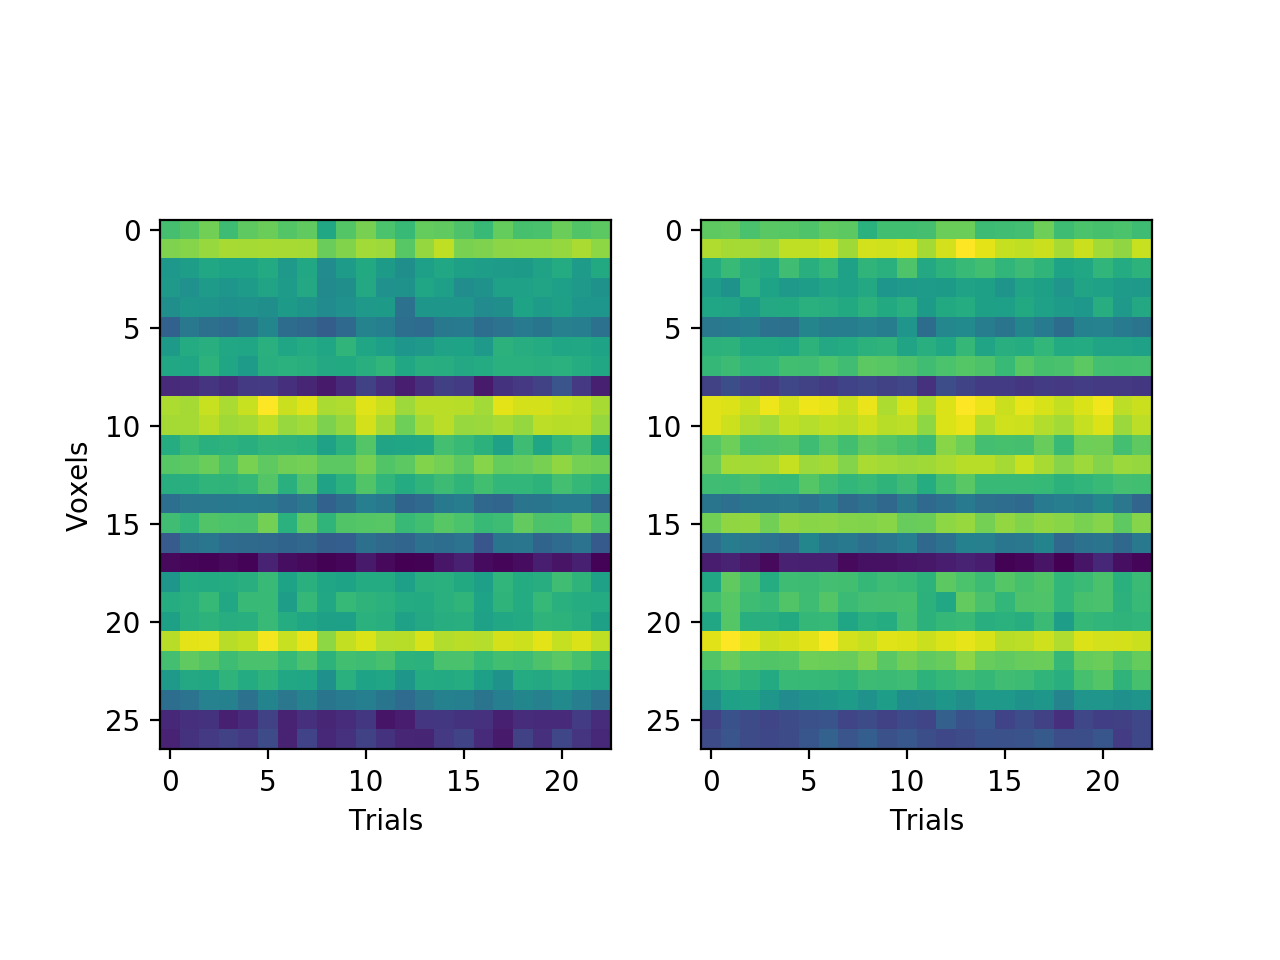

In [41]:
# Plot the pattern of activity for our signal voxels at each timepoint
plt.figure()
plt.subplot(1,2,1)
plt.imshow(trials_A)
plt.ylabel('Voxels')
plt.xlabel('Trials')
plt.subplot(1,2,2)
plt.imshow(trials_B)
plt.xlabel('Trials')

*4.2 Represent the data*

Treat each voxel as a dimension and each trial as a point in this voxel space. It is then possible to display the different conditions and determine whether these are separable in this lower dimensionality (note that the conditions may be separable in higher dimensionality but unsupervised techniques like Multidimensional Scaling used below, might not show such a difference)

<IPython.core.display.Javascript object>


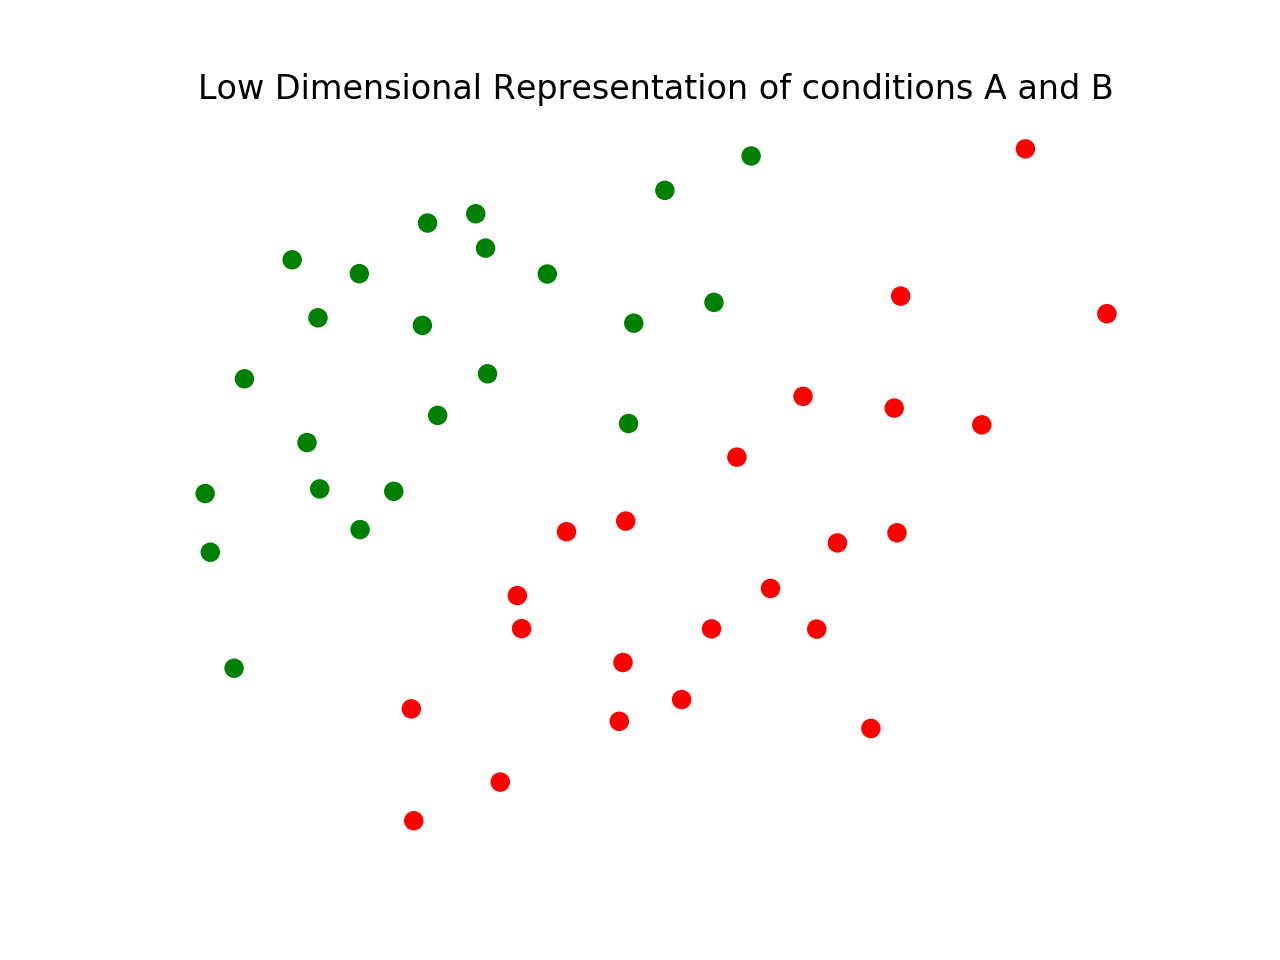

In [42]:
# Calculate the distance matrix between trial types
distance_matrix = sp_distance.squareform(sp_distance.pdist(np.vstack([trials_A.transpose(), trials_B.transpose()])))

mds = manifold.MDS(n_components=2, dissimilarity='precomputed')  # Fit the mds object
coords = mds.fit(distance_matrix).embedding_  # Find the mds coordinates

# Plot the data
plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=['red'] * trials_A.shape[1] + ['green'] * trials_B.shape[1])
plt.axis('off')
plt.title('Low Dimensional Representation of conditions A and B')

*4.2 Test for univariate effect*

Do a t test to compare the means of the voxels between these two conditions to determine if there is a difference

In [43]:
mean_difference = (np.mean(trials_A,0) - np.mean(trials_B,0))
ttest = stats.ttest_1samp(mean_difference, 0)

print('Mean difference between condition A and B: %0.2f\np value: %0.3f' % (mean_difference.mean(), ttest.pvalue))

Mean difference between condition A and B: -4.83
p value: 0.026


*4.3 Test for a multivariate effect*

Use SVM from scikit-learn to estimate the classification accuracy between the conditions

In [44]:
# Get the inputs to the SVM
input_mat = np.vstack([trials_A.transpose(), trials_B.transpose()])
input_labels = trials_A.shape[1] * [1] + trials_B.shape[1] * [0]

# Set up the classifier
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    input_mat, input_labels, test_size=0.2, random_state=0)

clf = sklearn.svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

score = clf.score(X_test, y_test)
print('Classification accuracy between condition A and B: %0.3f' % score)

Classification accuracy between condition A and B: 1.000


### **References**
Biswal, B., et al. (1996) Reduction of physiological fluctuations in fMRI using digital filters. Magnetic Resonance in Medicine 35, 107-113

Friedman, L. and Glover, G.H. (2006) Report on a multicenter fMRI quality assurance protocol. Journal of Magnetic Resonance Imaging 23, 827-839

Friston, K.J., et al. (1998) Event-related fMRI: characterizing differential responses. Neuroimage 7, 30-40

Gudbjartsson, H. and Patz, S. (1995) The Rician distribution of noisy MRI data. Magnetic resonance in medicine 34, 910-914

Welvaert, M., et al. (2011) neuRosim: An R package for generating fMRI data. Journal of Statistical Software 44, 1-18

Welvaert, M., & Rosseel, Y. (2013). On the definition of signal-to-noise ratio and contrast-to-noise ratio for fMRI data. PloS one, 8(11), e77089.
